I upsample the distribution of quasars in the SDSS survey using rejection sampling and inverse transfrom sampling.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy
from astroML.datasets import fetch_dr7_quasar

# I read the data and I save the redshift values

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

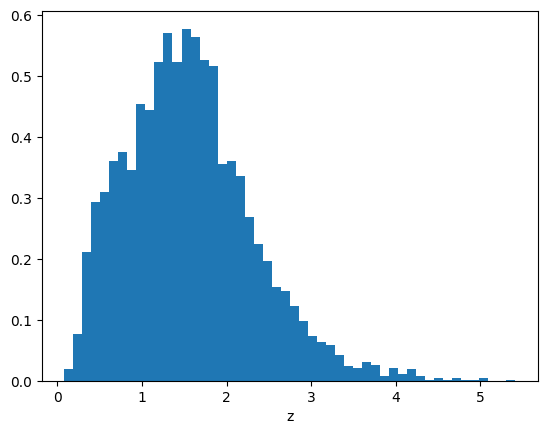

In [2]:
#I visualize the data
bins = 50
plt.hist(z, bins, density=True)
hist = np.histogram(z, bins, density=True)
plt.xlabel('z')
height = hist[0]
bin_edges = hist[1]

# Cloning by rejection sampling

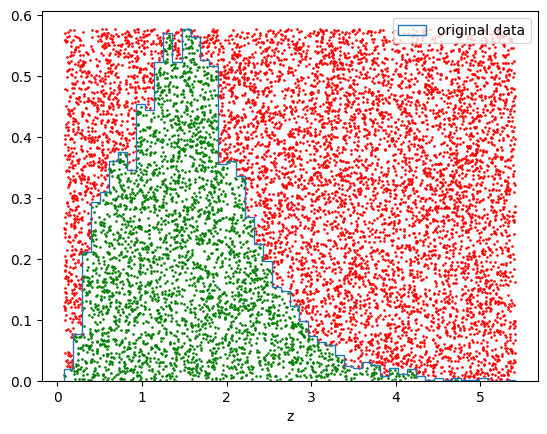

In [3]:
N = 10000
x_points = np.random.uniform(np.min(z), np.max(z), N)
y_points = np.random.uniform(0, np.max(height), N)

# I generate a data sample and I find the distribution given by the histogram
hist_distribution = scipy.stats.rv_histogram(hist, density=True)
def f(x):
    return hist_distribution.pdf(x)

# I accept only the points with y < f(x)
x_accepted_points = []
x_rejected_points = []
y_accepted_points = []
y_rejected_points = []
for i in range (len(x_points)):
    if y_points[i] < f(x_points[i]):
        x_accepted_points.append(x_points[i])
        y_accepted_points.append(y_points[i])
    else:
        x_rejected_points.append(x_points[i])
        y_rejected_points.append(y_points[i])

# I visualize the result
plt.hist(z, bins, density=True, label='original data', histtype='step')
plt.scatter(x_accepted_points, y_accepted_points, c='green', s=0.8)
plt.scatter(x_rejected_points, y_rejected_points, c='red', s=0.8)
plt.xlabel('z')
plt.legend()

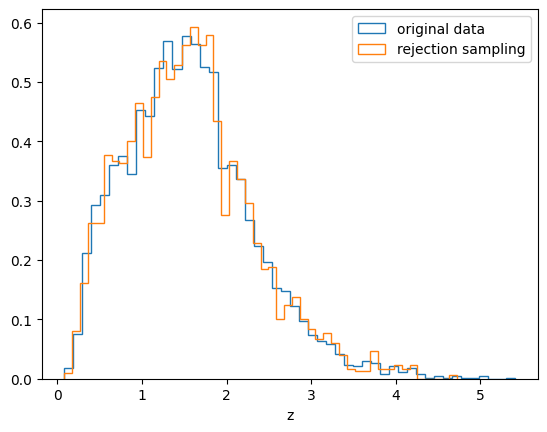

In [4]:
# Result obtained by rejection sampling
plt.hist(z, bins, density=True, label='original data', histtype='step')
plt.hist(x_accepted_points, bins, density=True, label='rejection sampling', histtype='step')
plt.xlabel('z')
plt.legend()

# Cloning by inverse transform sampling

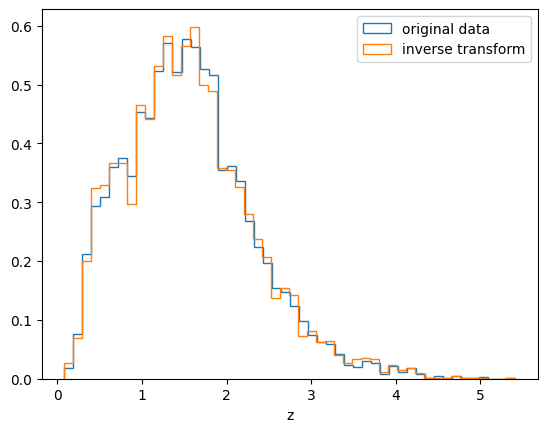

In [5]:
# I find the cdf
def cdf(x):
    return hist_distribution.cdf(x)

# I generate a uniform distribution and I invert the cdf to find a cloned distribution
uniform = np.random.uniform(0, 1, N)

cloned_x = []
for i in range (len(uniform)):
    cloned_x.append(scipy.optimize.brentq(lambda y : uniform[i]-cdf(y), np.min(z), np.max(z)))
    # brentq finds a root of the function uniform-cdf(y) on the sign changing interval [z_min , z_max]
    # this is equivalent to solving the equation y=inverse_cdf(uniform)

# result
plt.hist(z, bins, density=True, label='original data', histtype='step')
plt.hist(cloned_x, bins, density=True, label='inverse transform', histtype='step')
plt.xlabel('z')
plt.legend()

I can perform inverse transform sampling with another approach: I find the CDF points by hand (computing the cumulative heights of the histogram) and I interpolate the inverse function.

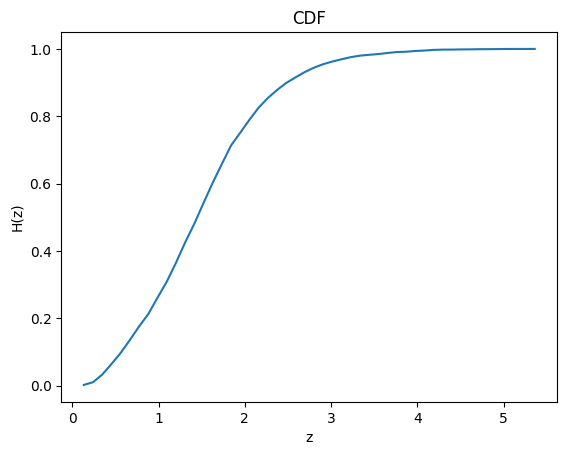

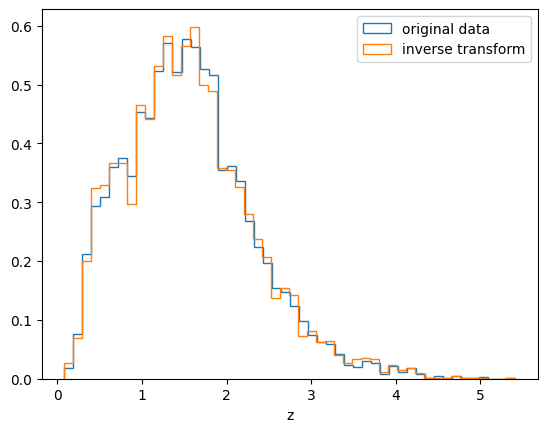

In [6]:
# I can also find the points of the cdf manually and then I can interpolate them

# x points
x_data = []
for i in range (len(bin_edges)-1):
    x_data.append((bin_edges[i]+bin_edges[i+1])/2)

#y points: I find te cumulative height for each x (I normalize it dividing by the sum of the heights)
y_data = np.cumsum(height)/np.sum(height)

# I visualize the cdf
plt.plot(x_data, y_data)
plt.xlabel('z')
plt.ylabel('H(z)')
plt.title('CDF')
plt.show()

# I interpolate the inverse function
inverse_cdf = scipy.interpolate.interp1d(y_data, x_data)

# I generate the uniform distribution and I find the cloned dataset
uniform = np.random.uniform(min(y_data),max(y_data), N) 
cloned_data = inverse_cdf(uniform)

# result
plt.hist(z, bins, density=True, label='original data', histtype='step')
plt.hist(cloned_x, bins, density=True, label='inverse transform', histtype='step')
plt.xlabel('z')
plt.legend()
plt.show()

# Cosmology

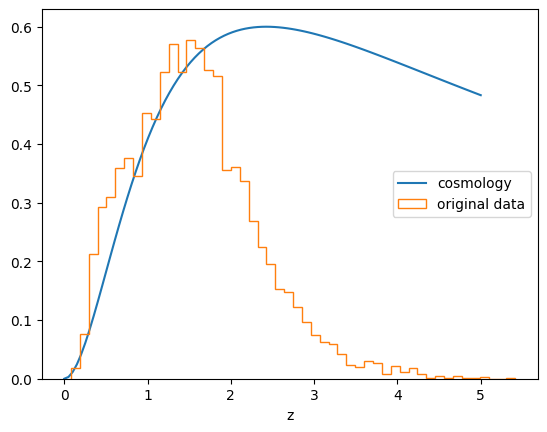

In [7]:
# we assume the quasars to be uniformly distributed in comoving volume in the Universe (constant number density=N_quasars/volume)
# for this reason I compare the z distribution with the differential comoving volume per redshift
import astropy

redshift = np.linspace(0, 5, 100)

def diff_comoving_vol(z):
    return 4 * np.pi * astropy.cosmology.Planck18.differential_comoving_volume(z)
# I multiply by 4pi beacuse differential_comoving_volume is also per steradian, so I multiply by the solid angle

volume = diff_comoving_vol(redshift)

# I need to normalize the volume (approximately)
normalized_volume = volume / np.max(volume) * 0.6  #0.6 is the maximum of the histogram

# result
plt.plot(redshift, normalized_volume, label='cosmology')
plt.hist(z, bins, density=True, label='original data', histtype='step')
plt.xlabel('z')
plt.legend()

The number of quasars per unit volume reaches a maximum somewhere around z=2; at earlier epochs (i.e., higher redshifts) they are rare. Detection of very high-redshift quasars is very important because their existence provides a constraint on the formation of large structures in the early Universe. An important factor in our observations is that at low z our catalogue is complete because observations are easier to perform, while at high z is very difficult to observe galaxies, so we surely measured only a fraction of the total.